# Energy Consumption Analysis for 15-minute Interval Data

This notebook provides a comprehensive analysis of energy consumption data that is recorded at 15-minute intervals. Our goal is to derive meaningful insights from the data and answer specific questions related to energy usage patterns.

**Key Objectives:**
1. Determine annual energy consumption.
2. Calculate the annual cost based on a given electricity price per kWh.
3. Analyze daily consumption patterns and monthly breakdowns.
4. Study consumption differences across days of the week.
5. Examine intra-day consumption distribution.
6. Identify days with peak consumption at 15-minute intervals.
7. Highlight the top 5 days with the highest instantaneous power usage.
8. Create a histogram to visualize quarterly consumption values relative to the total.
9. Compare solar panel production against consumption.
10. Optimize and understand car charger energy consumption.

## Beginning the Analysis

In this analysis, we examine the energy consumption data from multiple meters. The dataset provides consumption values in 15-minute intervals. Our goal is to preprocess this data and derive valuable insights from various perspectives, such as annual, daily, and intra-day consumption patterns.

### Setting up the Environment

To ensure our analysis runs smoothly, we'll first install and import the necessary libraries. These libraries provide functions and tools that will aid in data manipulation, visualization, and analysis.


In [45]:
# Installing necessary libraries
%pip install pandas matplotlib seaborn openpyxl

Note: you may need to restart the kernel to use updated packages.


### Data Preprocessing

The raw dataset contains date-time information in a non-standard format. In this step:

1. The dataset is loaded into a DataFrame.
2. A new DataFrame is created to hold the processed data.
3. The combined date-time column is split into separate date, start time, and end time values.
4. These separated values are then used to create two new columns: TimePeriodStart and TimePeriodEnd, which represent the start and end of each 15-minute interval in a standard datetime format.
5. The original combined date-time column is dropped.

In [46]:
# Imported libraries
import pandas as pd

# Load the dataset
data = pd.read_excel(r"C:\Users\mikloskiss\OneDrive - MOLGROUP\Personal\Repos\zengrid-analysis\src\Ivanics Autopark_hajo.xlsx", skiprows=[1])

# Create a copy for preprocessing
processed_data = data.copy()

# Extract date, start time, and end time from 'Időszeletek'
date = processed_data['Időszeletek'].str.split(' ').str[0]
start_time = processed_data['Időszeletek'].str.split(' - ').str[0].str.split(' ').str[1]
end_time = processed_data['Időszeletek'].str.split(' - ').str[1]

# Form full datetime strings
processed_data['TimePeriodStart'] = date + ' ' + start_time
processed_data['TimePeriodEnd'] = date + ' ' + end_time

# Adjust for '24:00' in TimePeriodEnd
mask_24 = processed_data['TimePeriodEnd'].str.endswith('24:00')
processed_data.loc[mask_24, 'TimePeriodEnd'] = (pd.to_datetime(processed_data.loc[mask_24, 'TimePeriodEnd'].str.split(' ').str[0]) + pd.Timedelta(days=1)).dt.strftime('%Y.%m.%d') + ' 00:00'

# Convert 'TimePeriodStart' and 'TimePeriodEnd' to ISO format
processed_data['TimePeriodStart'] = pd.to_datetime(processed_data['TimePeriodStart'], format='%Y.%m.%d %H:%M')
processed_data['TimePeriodEnd'] = pd.to_datetime(processed_data['TimePeriodEnd'], format='%Y.%m.%d %H:%M')

## Extract day of the week, month, hour, and minute from 'TimePeriodStart'
processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek
processed_data['Month'] = processed_data['TimePeriodStart'].dt.month
processed_data['Hour'] = processed_data['TimePeriodStart'].dt.hour
processed_data['Minute'] = processed_data['TimePeriodStart'].dt.minute

# Drop the original 'Időszeletek' column
processed_data.drop('Időszeletek', axis=1, inplace=True)

# Display the processed data and its types
processed_data.head(), processed_data.dtypes


(   HU000210F11-S00000000000005002818  HU000210F11-S00000000000005002818/term  \
 0                              3.488                                     0.0   
 1                              3.488                                     0.0   
 2                              3.450                                     0.0   
 3                              3.538                                     0.0   
 4                              3.763                                     0.0   
 
    HU000210F11-S00000000000005003426  HU000210F11-S00000000000005003426/term  \
 0                               2.40                                     0.0   
 1                               2.40                                     0.0   
 2                               2.26                                     0.0   
 3                               2.56                                     0.0   
 4                               2.44                                     0.0   
 
    HU000210F11-S0000000

### Task 1: Calculate annual consumption
This task involves understanding the annual consumption of each meter and calculating associated costs:

1. The annual consumption for each meter is computed by summing up its respective values.
2. The annual cost for each meter is derived using a given price per kWh.
3. Average daily consumption is computed for each 15-minute interval throughout the entire year.
4. Average monthly consumption is calculated for each 15-minute interval, grouped by month.
5. A visualization is created to showcase the average consumption per hour throughout the year.

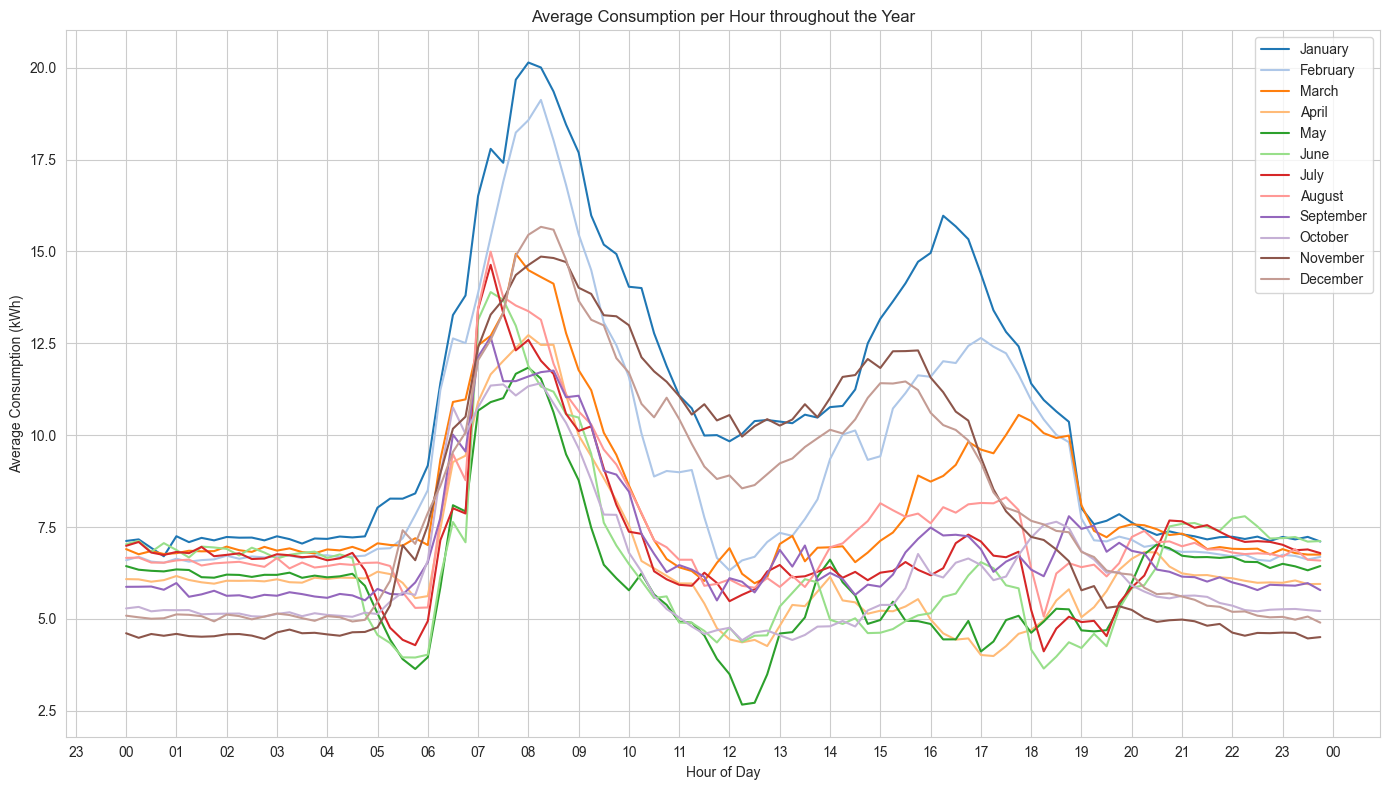

In [47]:
# Imported libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar

# Add your own variable(s) here
price_per_kwh = 183.5

# Step 1: Calculate annual consumption
consumption_cols = [col for col in processed_data.columns if '/term' not in col and 'TimePeriod' not in col]
annual_consumption = processed_data[consumption_cols].sum()

# Step 2: Calculate annual costs
annual_costs = annual_consumption * price_per_kwh

# Step 3: Average daily consumption for each 15-minute interval
processed_data['Hour'] = processed_data['TimePeriodStart'].dt.hour
processed_data['Minute'] = processed_data['TimePeriodStart'].dt.minute
avg_daily_consumption = processed_data.groupby(['Hour', 'Minute']).mean().reset_index()

# Step 4: Average daily consumption for each 15-minute interval grouped by month
processed_data['Month'] = processed_data['TimePeriodStart'].dt.month
avg_monthly_consumption = processed_data.groupby(['Month', 'Hour', 'Minute']).mean().reset_index()

# Generating time column for plotting
avg_monthly_consumption['Time'] = avg_monthly_consumption['Hour'].astype(str).str.zfill(2) + ':' + avg_monthly_consumption['Minute'].astype(str).str.zfill(2)
avg_monthly_consumption['PlotTime'] = pd.to_datetime('2000-01-01 ' + avg_monthly_consumption['Time'])

# Calculating total consumption across meters
consumption_columns = [
    "HU000210F11-S00000000000005002818",
    "HU000210F11-S00000000000005003426",
    "HU000210F11-S00000000000016231220"
]
avg_monthly_consumption['TotalConsumption'] = avg_monthly_consumption[consumption_columns].sum(axis=1)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
palette = sns.color_palette("tab20", len(avg_monthly_consumption['Month'].unique()))

for month, color in zip(avg_monthly_consumption['Month'].unique(), palette):
    monthly_data = avg_monthly_consumption[avg_monthly_consumption['Month'] == month]
    ax.plot(monthly_data['PlotTime'], monthly_data['TotalConsumption'], label=calendar.month_name[month], color=color)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Consumption (kWh)")
ax.set_title("Average Consumption per Hour throughout the Year")
ax.legend()

plt.tight_layout()
plt.show()

### Task 2: Daily Consumption Patterns and Monthly Breakdowns

This task aims to identify patterns in consumption across different days of the week:

1. Average consumption values for each day of the week are computed.
2. A bar chart is created to showcase the average consumption for each day, from Monday to Sunday.

In [48]:
print(processed_data[consumption_columns].dtypes)

HU000210F11-S00000000000005002818    float64
HU000210F11-S00000000000005003426    float64
HU000210F11-S00000000000016231220    float64
dtype: object


In [49]:
# Just computing the mean without grouping
print(processed_data[consumption_columns].mean())

# Grouping by only one column
print(processed_data.groupby('Month').mean()[consumption_columns])


HU000210F11-S00000000000005002818    4.602057
HU000210F11-S00000000000005003426    2.131052
HU000210F11-S00000000000016231220    0.867646
dtype: float64
       HU000210F11-S00000000000005002818  HU000210F11-S00000000000005003426  \
Month                                                                         
1                               5.699197                           3.955334   
2                               5.127631                           3.095109   
3                               4.573060                           2.616541   
4                               3.818389                           1.754444   
5                               4.000009                           1.219362   
6                               4.378736                           1.240146   
7                               5.025371                           1.313172   
8                               5.412421                           1.344140   
9                               4.469651                 

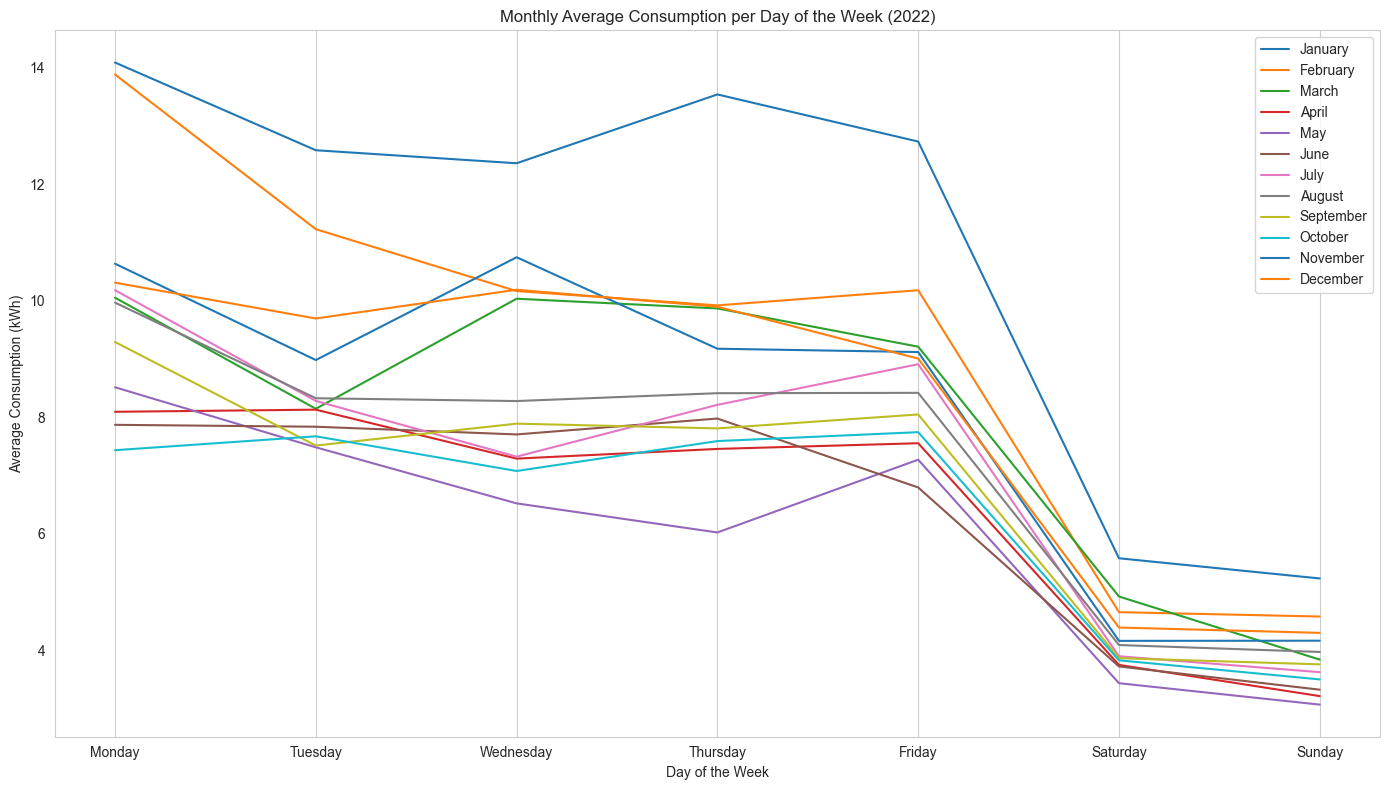

In [50]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Filter out non-consumption columns
consumption_columns = [col for col in processed_data.columns if '/term' not in col and 'TimePeriod' not in col and col != 'DayOfWeek' and col != 'Month' and col != 'Hour' and col != 'Minute']

# Calculate average consumption for each day of the week for each month
avg_monthly_weekly_consumption = processed_data.groupby(['Month', 'DayOfWeek']).mean()[consumption_columns].reset_index()
avg_monthly_weekly_consumption['DayOfWeek'] = avg_monthly_weekly_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])


# Visualization
plt.figure(figsize=(14, 8))

for month in range(1, 13):
    monthly_data = avg_monthly_weekly_consumption[avg_monthly_weekly_consumption['Month'] == month]
    
    plt.plot(monthly_data['DayOfWeek'], monthly_data[consumption_columns].sum(axis=1), label=calendar.month_name[month])

plt.ylabel('Average Consumption (kWh)')
plt.xlabel('Day of the Week')
plt.title('Monthly Average Consumption per Day of the Week (2022)')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

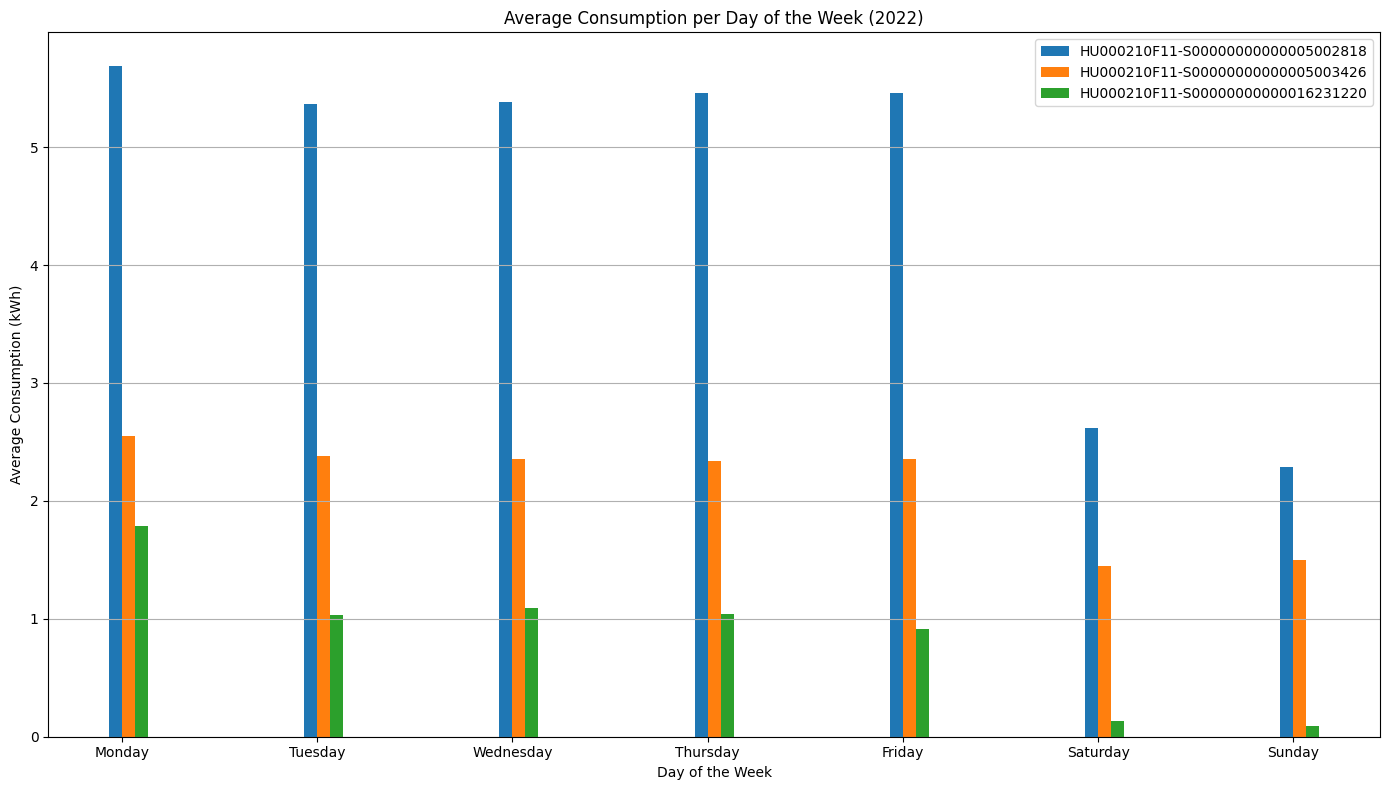

In [32]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

# Ensure 'DayOfWeek' column exists
if 'DayOfWeek' not in processed_data.columns:
    processed_data['DayOfWeek'] = processed_data['TimePeriodStart'].dt.dayofweek

# Filter out non-consumption columns from the list
consumption_columns = [col for col in processed_data.columns if '/term' not in col and 'TimePeriod' not in col and col != 'DayOfWeek' and col != 'Month' and col != 'Hour' and col != 'Minute']

# Calculate average consumption for each day of the week
avg_weekly_consumption = processed_data.groupby('DayOfWeek').mean()[consumption_columns].reset_index()

# Convert numerical day representation to actual day names
avg_weekly_consumption['DayOfWeek'] = avg_weekly_consumption['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Order days of the week correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_weekday_consumption = avg_weekly_consumption.set_index('DayOfWeek').reindex(days_order).reset_index()

# Visualization
plt.figure(figsize=(14, 8))

width = 0.2  # bar width
x = np.arange(len(days_order))  # label locations

# Adjust the width depending on the number of consumption columns to ensure non-overlapping bars
width = width / len(consumption_columns)

# Plot data for each consumption column
for idx, column in enumerate(consumption_columns, 1):
    plt.bar(x - width * len(consumption_columns) / 2 + idx * width, avg_weekday_consumption[column], width, label=column)

plt.ylabel('Average Consumption (kWh)')
plt.xlabel('Day of the Week')
plt.title('Average Consumption per Day of the Week (2022)')
plt.xticks(x, days_order)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Task 3: Examining Intra-day Consumption Distribution

This task delves into the consumption patterns within a day:

1. The data is grouped by hours and minutes to determine the average consumption for each 15-minute interval throughout the day.
2. A line plot is created to show the intra-day distribution of average consumption.

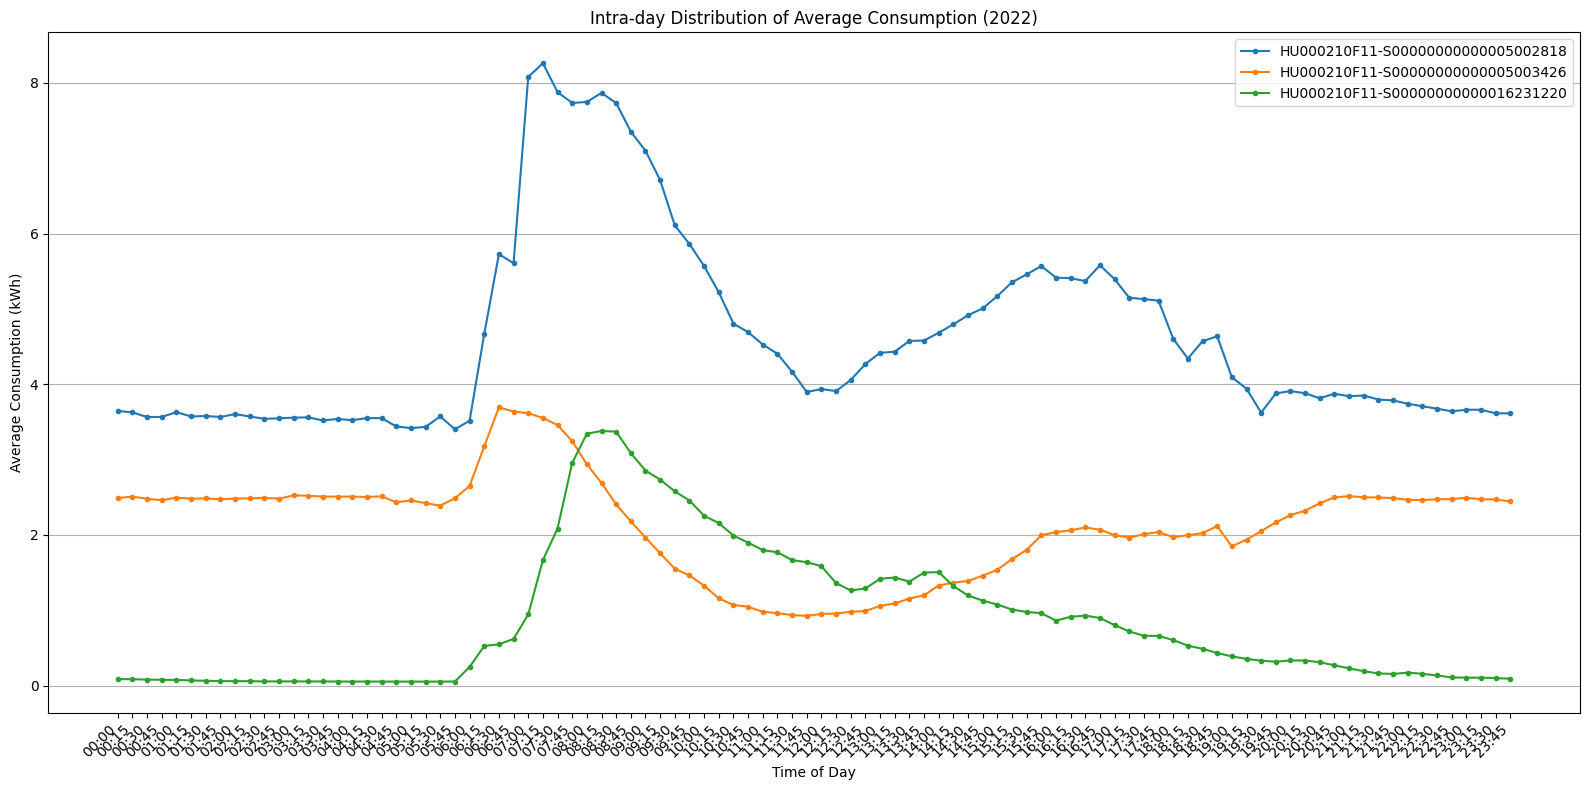

In [33]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Calculate average consumption for each 15-minute interval of the day

# As we have already extracted 'Hour' and 'Minute' in the preprocessing step, we can directly compute the average.
avg_intra_day = processed_data.groupby(['Hour', 'Minute']).mean()[consumption_columns].reset_index()

# Convert 'Hour' and 'Minute' to a time format for better visualization
avg_intra_day['Time'] = avg_intra_day['Hour'].astype(str).str.zfill(2) + ':' + avg_intra_day['Minute'].astype(str).str.zfill(2)

# Step 2: Visualization of intra-day consumption patterns

plt.figure(figsize=(16, 8))

# Plot data for each consumption column
for column in consumption_columns:
    plt.plot(avg_intra_day['Time'], avg_intra_day[column], label=column, marker='o', markersize=3)

# Set labels, title, and format the x-axis
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Distribution of Average Consumption (2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 4: Identifying Days with Peak Consumption at 15-minute Intervals

This task focuses on identifying periods of peak consumption:

1. The data is analyzed to find the 15-minute intervals with the highest total power consumption.
2. The top 5 unique days with the highest instantaneous power are identified.
3. A line plot is created to show the intra-day power distribution for these top 5 unique days.

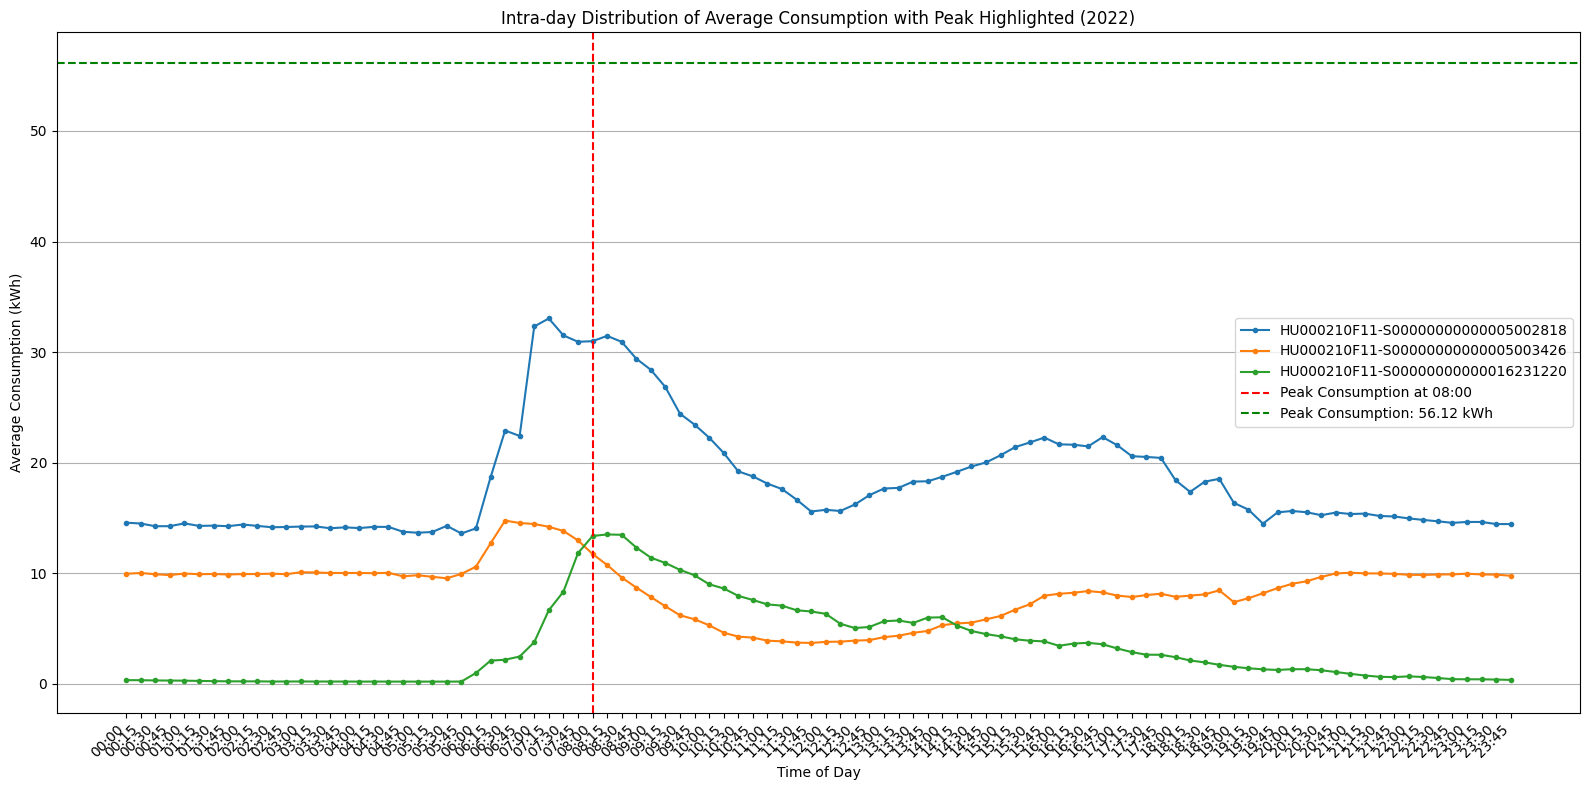

In [34]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert to kWh
# Multiplying by 4 to convert kW readings of 15-minute intervals to kWh
avg_intra_day[consumption_columns] *= 4

# Step 2: Calculate total consumption for each time interval
avg_intra_day['Total'] = avg_intra_day[consumption_columns].sum(axis=1)

# Step 3: Identify peak consumption time
peak_time = avg_intra_day.iloc[avg_intra_day['Total'].idxmax()]['Time']
peak_value = avg_intra_day['Total'].max()

# Step 4: Visualization

plt.figure(figsize=(16, 8))

# Plot data for each consumption column
for column in consumption_columns:
    plt.plot(avg_intra_day['Time'], avg_intra_day[column], label=column, marker='o', markersize=3)

# Highlight the peak consumption period
plt.axvline(peak_time, color='red', linestyle='--', label=f'Peak Consumption at {peak_time}')
plt.axhline(peak_value, color='green', linestyle='--', label=f'Peak Consumption: {peak_value:.2f} kWh')

# Set labels, title, and format the x-axis
plt.xlabel('Time of Day')
plt.ylabel('Average Consumption (kWh)')
plt.title('Intra-day Distribution of Average Consumption with Peak Highlighted (2022)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Task 5: Identify the top 5 days with the highest instantaneous power.
The focus of this task is to pinpoint periods of peak consumption:

1. **Highlighting Peak Intervals**:
    - The dataset is first scoured to identify the 15-minute intervals with the top 5 highest total power consumptions. It's worth noting that multiple peak values might occur on the same day. The visual representation of this data will underscore these peak values, allowing us to identify the most power-intensive moments throughout the year.
2. **Analysis of Unique Peak Days**:
    - To get a broader view, we delve deeper to identify the top 5 unique days that experienced the highest instantaneous power. This approach ensures we're not just looking at isolated peak intervals but rather entire days of significant power usage.
    - A line plot is then crafted to vividly display the intra-day power distribution for each of these standout days, painting a clear picture of consumption dynamics on these particularly demanding days.

By the culmination of this task, we'll have a nuanced understanding of both instantaneous power spikes and broader days of high consumption, offering a multifaceted view of peak usage periods.

Top 5 Dates with the Highest Instantaneous Power:
2022-01-24
2022-07-04


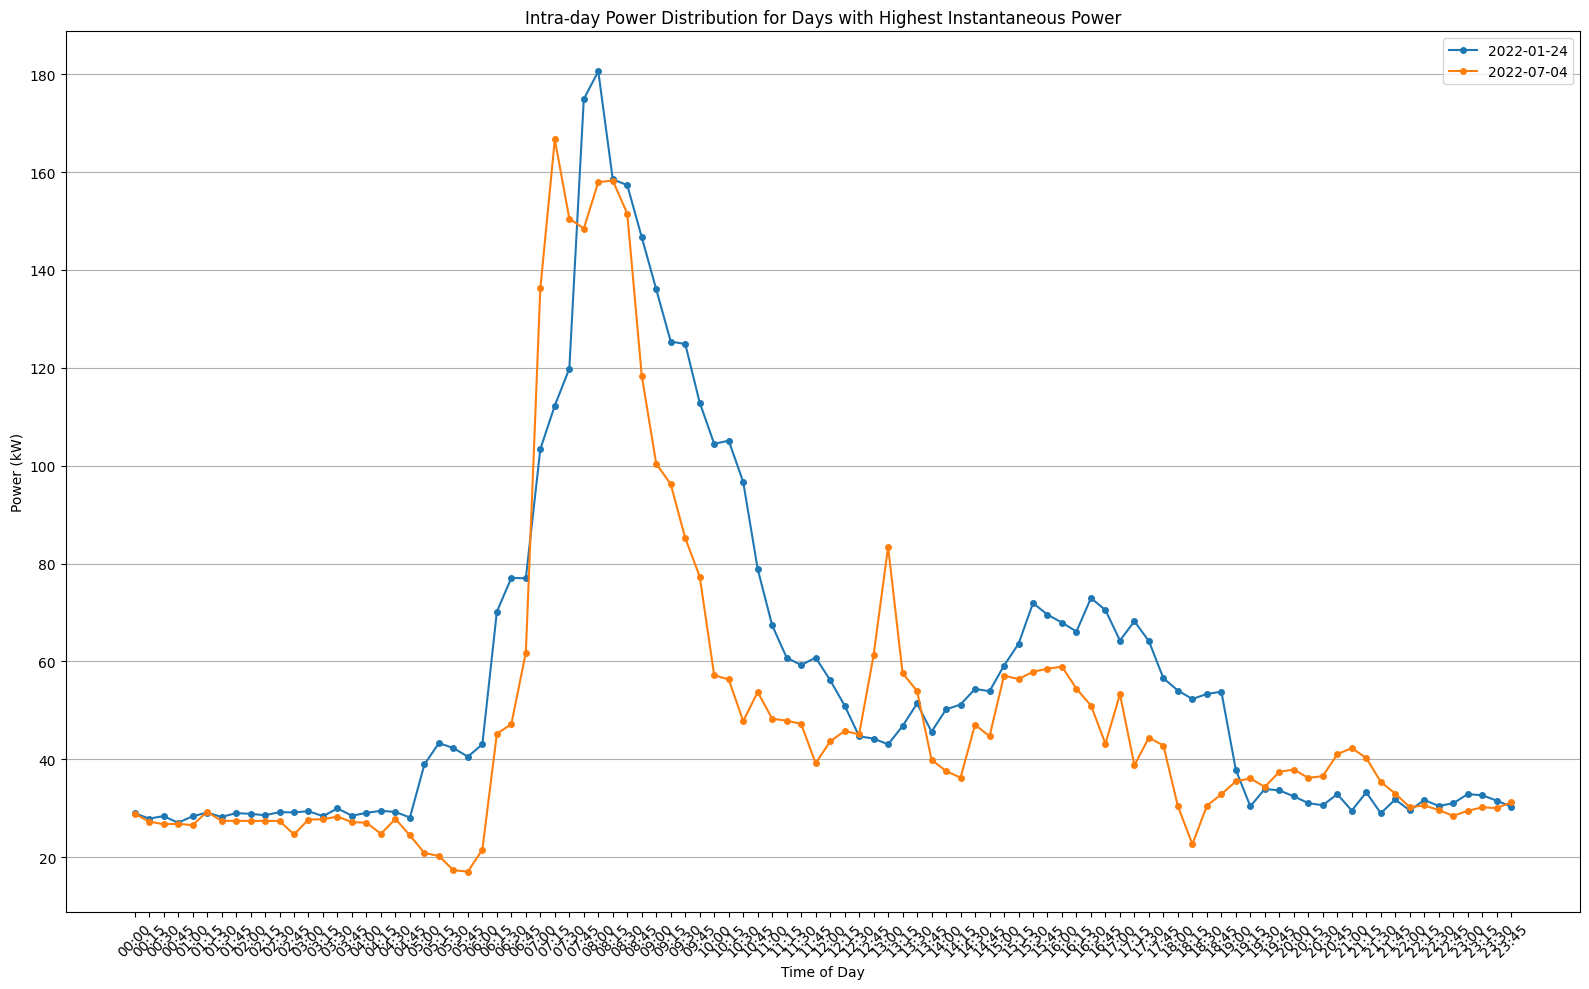

In [36]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert consumption to power (kW)
# Since the data is for 15-minute intervals, we multiply by 4 to get kW
processed_data[consumption_columns] *= 4

# Calculate total power for each interval
processed_data['TotalPower'] = processed_data[consumption_columns].sum(axis=1)

# Step 2: Identify top 5 intervals with the highest power
top_5_intervals = processed_data.nlargest(5, 'TotalPower')

# Step 3: Extract unique dates from top intervals
unique_top_dates = top_5_intervals['TimePeriodStart'].dt.date.unique()

print("Top 5 Dates with the Highest Instantaneous Power:")
for date in unique_top_dates:
    print(date)

# Step 4: Visualization

plt.figure(figsize=(16, 10))

# Plotting intra-day distribution for each unique top date
for date in unique_top_dates:
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    time = subset['TimePeriodStart'].dt.strftime('%H:%M')
    plt.plot(time, subset['TotalPower'], label=str(date), marker='o', markersize=4)

# Adjusting the plot
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Intra-day Power Distribution for Days with Highest Instantaneous Power')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

Top 5 Dates with the Highest Instantaneous Power:
2022-02-21
2022-02-28
2022-01-17
2022-03-07
2022-01-27


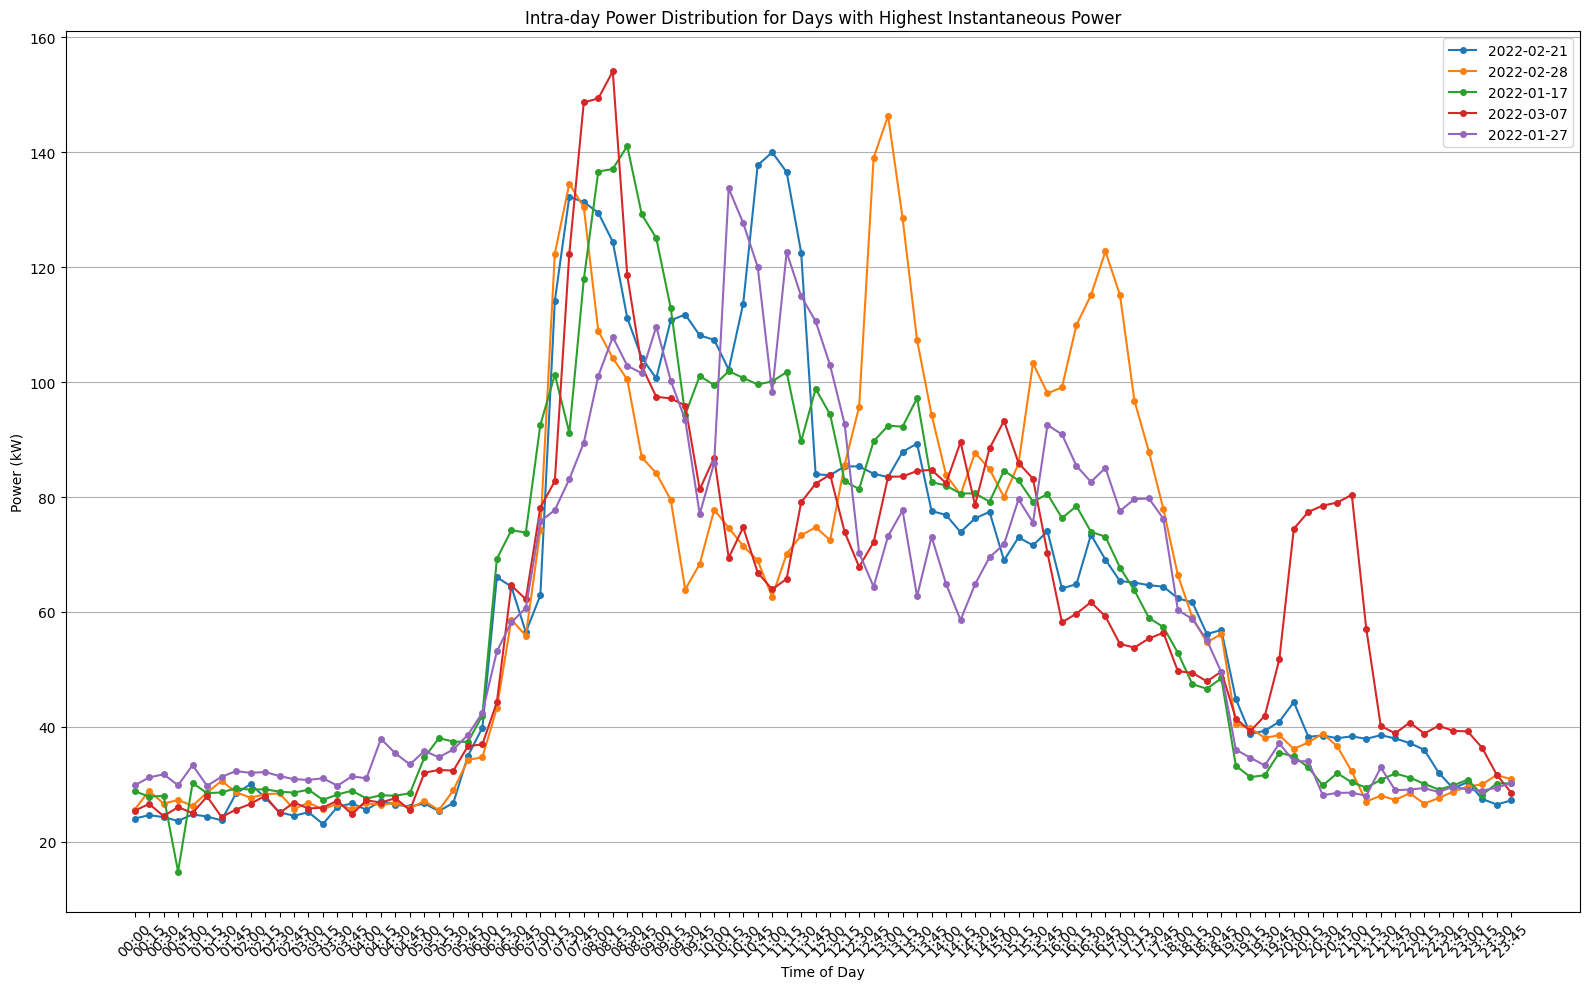

In [37]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate daily total power
daily_total_power = processed_data.groupby(processed_data['TimePeriodStart'].dt.date)['TotalPower'].sum()

# Get top 5 unique dates with the highest total power
top_5_dates = daily_total_power.nlargest(5).index

print("Top 5 Dates with the Highest Instantaneous Power:")
for date in top_5_dates:
    print(date)

# Visualization
plt.figure(figsize=(16, 10))

# Plotting intra-day distribution for each unique top date
for date in top_5_dates:
    subset = processed_data[processed_data['TimePeriodStart'].dt.date == date]
    time = subset['TimePeriodStart'].dt.strftime('%H:%M')
    plt.plot(time, subset['TotalPower'], label=str(date), marker='o', markersize=4)

# Adjusting the plot
plt.xlabel('Time of Day')
plt.ylabel('Power (kW)')
plt.title('Intra-day Power Distribution for Days with Highest Instantaneous Power')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()

### Task 6: Visualizing Quarterly Consumption

This task aims to understand the distribution of daily energy consumption for each meter:

1. Histograms are created for each meter to show the distribution of daily energy consumption values.
2. These histograms provide insights into the frequency of different daily consumption values for each meter, highlighting common consumption patterns and any anomalies.

c:\Users\mikloskiss\OneDrive - MOLGROUP\Personal\Repos\zengrid-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mikloskiss\OneDrive - MOLGROUP\Personal\Repos\zengrid-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mikloskiss\OneDrive - MOLGROUP\Personal\Repos\zengrid-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\mikloskiss\OneDrive - MOLGROUP\Personal\Repos\zengrid-

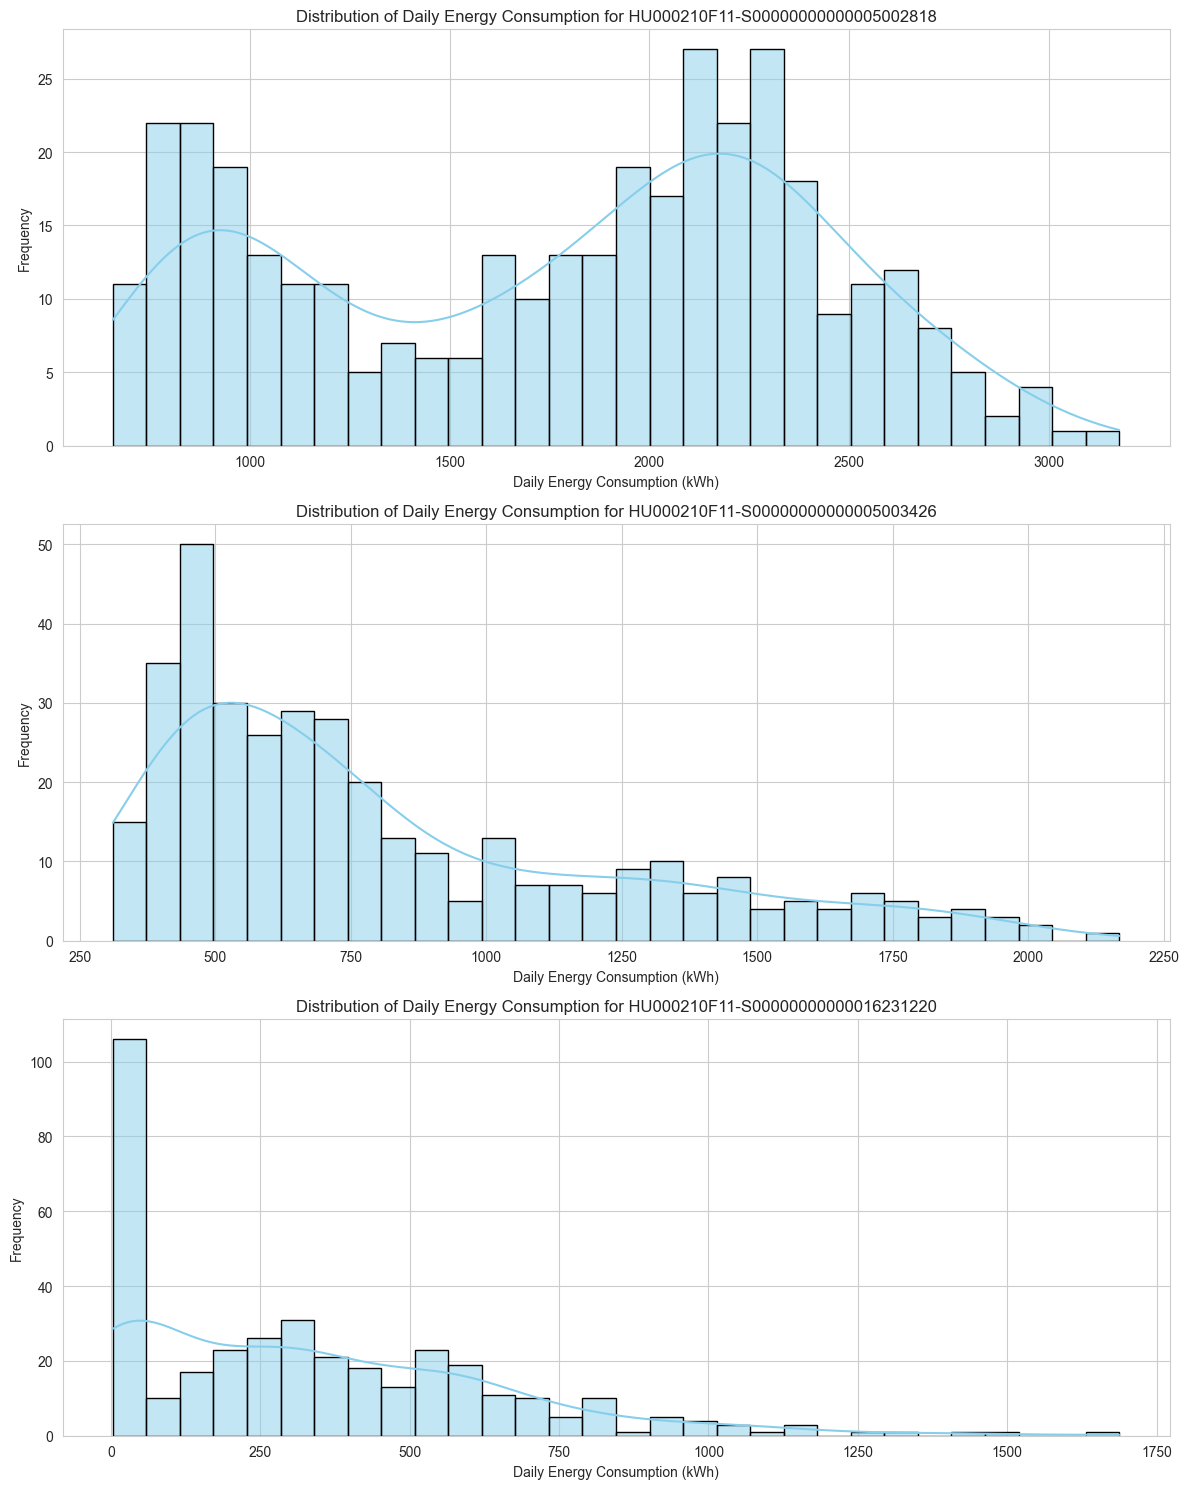

In [38]:
# Imported libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the daily energy consumption for each meter
processed_data['Date'] = processed_data['TimePeriodStart'].dt.date
daily_consumption = processed_data.groupby('Date')[consumption_columns].sum()

# Setting up the plotting environment
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

# Plotting histograms for each meter
for idx, column in enumerate(consumption_columns):
    sns.histplot(daily_consumption[column], ax=axes[idx], bins=30, kde=True, color='skyblue', edgecolor='black')
    
    # Setting titles and labels for each subplot
    axes[idx].set_title(f'Distribution of Daily Energy Consumption for {column}')
    axes[idx].set_xlabel('Daily Energy Consumption (kWh)')
    axes[idx].set_ylabel('Frequency')

# Adjusting the layout to prevent overlap
plt.tight_layout()

# Displaying the plots
plt.show()


### Task 8: Anomaly detection
Here's a basic approach to detect anomalies using the interquartile range (IQR):

IQR Method:
- Calculate the first (Q1) and third quartiles (Q3) for the data.
- Compute the IQR: IQR=Q3−Q1IQR=Q3−Q1.
- Define a threshold for outliers, typically 1.5 times the IQR below Q1 and above Q3.
- Data points outside of this range are considered anomalies.

Let's implement this for daily energy consumption:

In [39]:
# Add your own variable(s) here
# FYI: The threshold for outliers is 1.5 by default, 1.0 and 1.2 is stricter, 2.0 is more lenient
threshold_for_outliers = 1.5

# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
thresholds = {}

for column in consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold_for_outliers * IQR
    upper_bound = Q3 + threshold_for_outliers * IQR
    
    thresholds[column] = {"Lower Bound": lower_bound, "Upper Bound": upper_bound}

# Display thresholds for each meter
for meter, bounds in thresholds.items():
    print(f"Thresholds for {meter}:")
    print(f"  - Lower Bound: {bounds['Lower Bound']:.2f}")
    print(f"  - Upper Bound: {bounds['Upper Bound']:.2f}")
    print("\n")


Thresholds for HU000210F11-S00000000000005002818:
  - Lower Bound: -651.47
  - Upper Bound: 4038.81


Thresholds for HU000210F11-S00000000000005003426:
  - Lower Bound: -356.00
  - Upper Bound: 1876.32


Thresholds for HU000210F11-S00000000000016231220:
  - Lower Bound: -753.12
  - Upper Bound: 1315.36




In [ ]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
anomaly_dates = {}

for column in consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold_for_outliers * IQR
    upper_bound = Q3 + threshold_for_outliers * IQR
    
    # Extract dates of the anomalies
    anomaly_dates[column] = daily_consumption[(daily_consumption[column] < lower_bound) | (daily_consumption[column] > upper_bound)].index

# Display dates of anomalies for each meter
for meter, dates in anomaly_dates.items():
    print(f"Anomaly Dates for {meter}:")
    for date in dates:
        print(f"  - {date.strftime('%Y-%m-%d')}")
    print("\n")


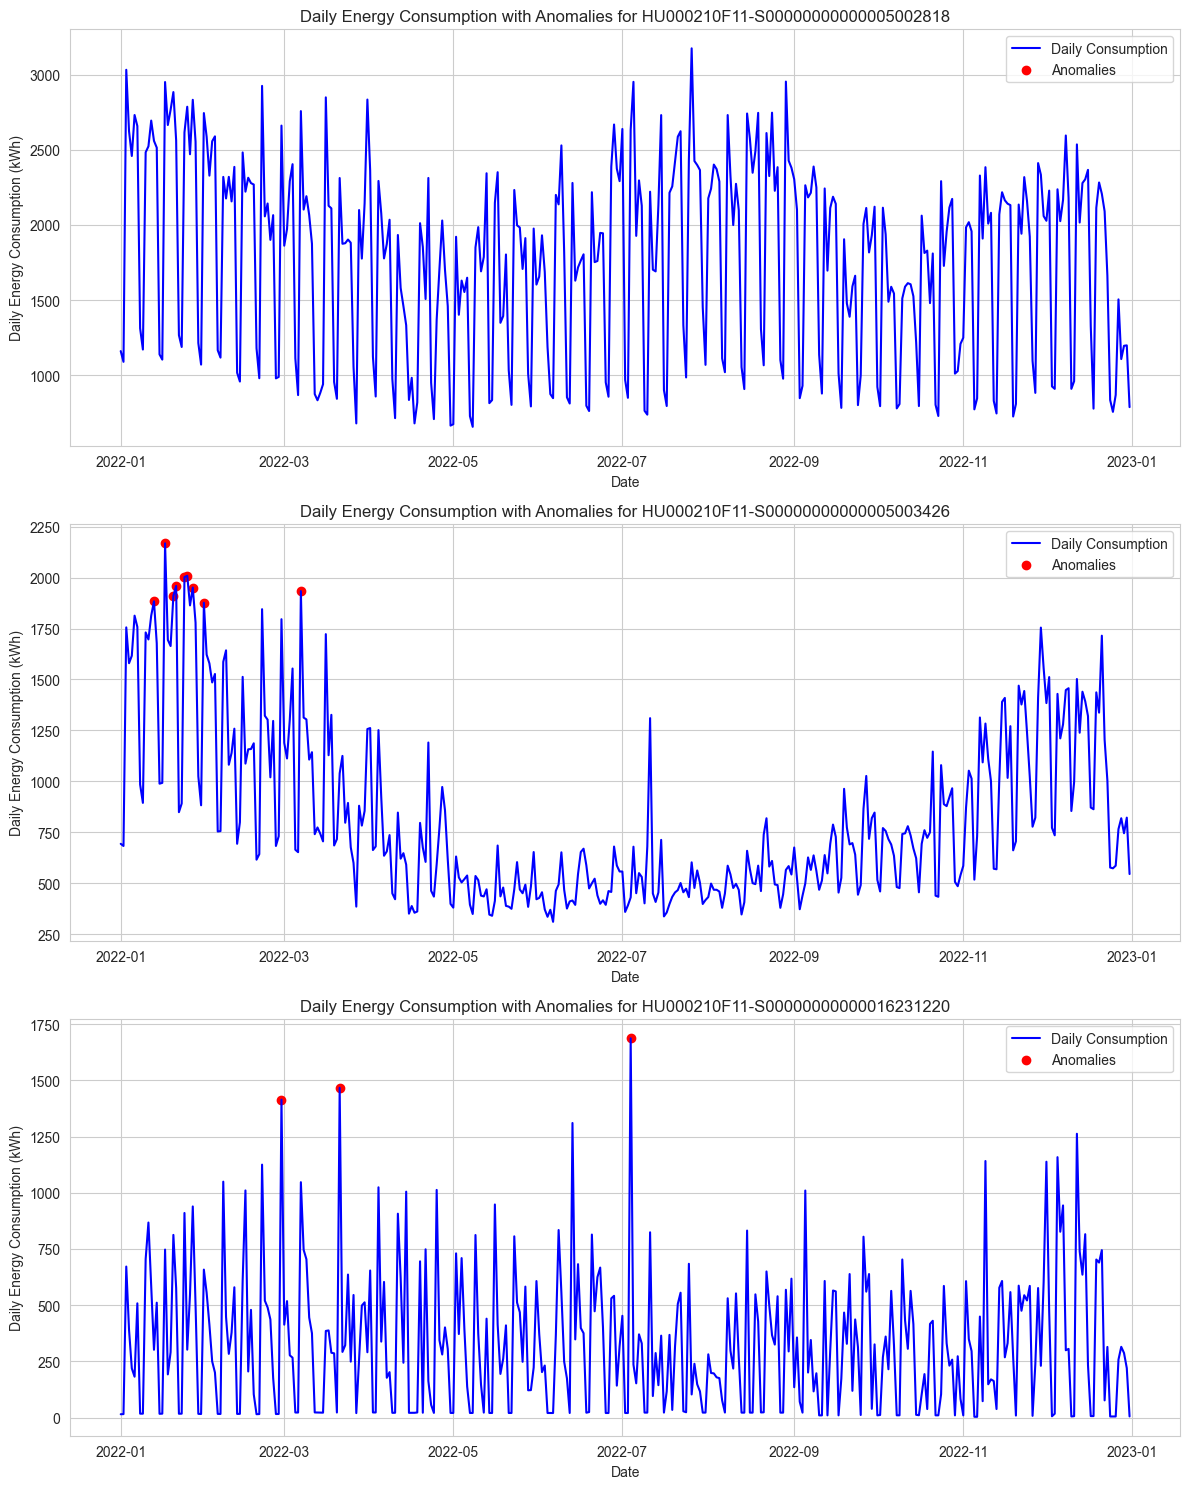

In [40]:
# For each meter, calculate Q1, Q3, IQR, and the bounds for outliers
anomalies = {}

for column in consumption_columns:
    Q1 = daily_consumption[column].quantile(0.25)
    Q3 = daily_consumption[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold_for_outliers * IQR
    upper_bound = Q3 + threshold_for_outliers * IQR
    
    # Filter out the anomalies
    anomalies[column] = daily_consumption[(daily_consumption[column] < lower_bound) | (daily_consumption[column] > upper_bound)]

# Plotting the daily consumption along with anomalies
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

for idx, column in enumerate(consumption_columns):
    axes[idx].plot(daily_consumption.index, daily_consumption[column], label='Daily Consumption', color='blue')
    axes[idx].scatter(anomalies[column].index, anomalies[column][column], color='red', label='Anomalies')
    axes[idx].set_title(f'Daily Energy Consumption with Anomalies for {column}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Daily Energy Consumption (kWh)')
    axes[idx].legend()

plt.tight_layout()
plt.show()

### Task 8: Solar Panel Production vs Consumption

One of the sustainable solutions to energy needs is harnessing solar power. In this section, we'll compare solar panel production against consumption. This will provide insights into how self-produced energy matches up against consumption and where additional energy sources might be needed.

In [ ]:
#TODO: analysis of the PV panels vs Consumption
# CODE HERE

### Task 9: Understanding Car Charger Energy Consumption

Electric vehicles are becoming increasingly popular. Understanding the energy consumption associated with car charging can provide insights into the overall energy usage patterns and potential optimizations.

In [ ]:
# TODO: add a function that calculates the cost of charging a car based on the time of day
# CODE HERE

### Task 10: Final Observations and Conclusions

After analyzing various facets of the energy consumption data, it's essential to consolidate our findings, draw conclusions, and provide actionable insights. In this section, we'll summarize the key observations and suggest further steps or considerations.